In [1]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, '/home/pklein/Documents/GitHub/pypsa_utilities/eskom data/')

import data_utilities as du
import plotting_utilities as pu
import financial_utilities as fu
import xarray as xr
import cartopy.crs as ccrs
from pypsa.descriptors import get_switchable_as_dense as get_as_dense
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np
from shapely.geometry import shape
import rioxarray
import atlite
import shapely
import plotly.graph_objects as go
import plotly.offline as pltly

import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning) 


ERROR 1: PROJ: proj_create_from_database: Open of /home/pklein/anaconda3/envs/pypsa-eur/share/proj failed


In [12]:
n = pypsa.Network('../results/networks/solved_CSIR-ambitions-2022_27-supply_redz_lcopt_LC-1H.nc')

In [3]:
reserve_type='total'
carriers = ['battery','PHS']
carriers=['diesel','gas','OCGT','CCGT','battery','PHS'] 
y=2030
p_nom=n.generators.p_nom_opt[n.get_active_assets('Generator',y) & n.generators.carrier.isin(carriers)].sum()+n.storage_units.p_nom_opt[n.get_active_assets('StorageUnit',y)].sum()
(p_nom-n.generators_t.p.loc[y][n.generators.p_nom_opt[n.get_active_assets('Generator',y) & n.generators.carrier.isin(carriers)].index].sum(axis=1)-n.storage_units_t.p_dispatch.loc[y].sum(axis=1)).min()

ValueError: Investment period not in `network.investment_periods`

In [4]:
capacity=pd.DataFrame(np.nan,index=np.append(n.generators.carrier.unique(),n.storage_units.carrier.unique()),columns=range(n.investment_periods[0],n.investment_periods[-1]+1))       
carriers=n.generators.carrier.unique()
carriers = carriers[carriers !='load_shedding']
for y in n.investment_periods:
    capacity.loc[carriers,y]=n.generators.p_nom_opt[(n.get_active_assets('Generator',y))].groupby(n.generators.carrier).sum()

carriers=n.storage_units.carrier.unique()
for y in n.investment_periods:
    capacity.loc[carriers,y]=n.storage_units.p_nom_opt[(n.get_active_assets('StorageUnit',y))].groupby(n.storage_units.carrier).sum()



In [5]:
capacity=capacity.T.interpolate().T

In [6]:
capacity=capacity.reindex(['nuclear','coal','CCGT','OCGT','diesel','gas','hydro','PHS','biomass','CSP','onwind','solar','battery'])

In [7]:
colour_map={'onwind':'#77D1E4',
            'onwind_100MW':'#2eb8d6',
            'solar':'#FFBB4E',
            'solar_pv_1MW':'#FBDC81',
            'solar_pv_100MW':'#F99B00',
            'CSP':'#feed82',
            'battery':'#cba3cb',
            'bat_c':'#AA68AA',#CBA3CB
            'bat_d':'#AA68AA',
            'PHS':'#873f91',
            'phs_c':'#873f91',
            'phs_d':'#873f91',
            'coal':'#3C3C3C',
            'hydro':'#004F95',
            'ocgt':'#8D7867',
            'diesel':'#8D7867',
            'gas':'#8D7867',
            'OCGT':'#8D7867',
            'CCGT':'#ffa69e',
            'rmippp':'#51969B',
            'biomass':'#8C9A07',
            'nuclear':'#C84936',
            'demand_response':'#817E80',
            'loadshedding':'#DE9287'}

(0.0, 200.0)

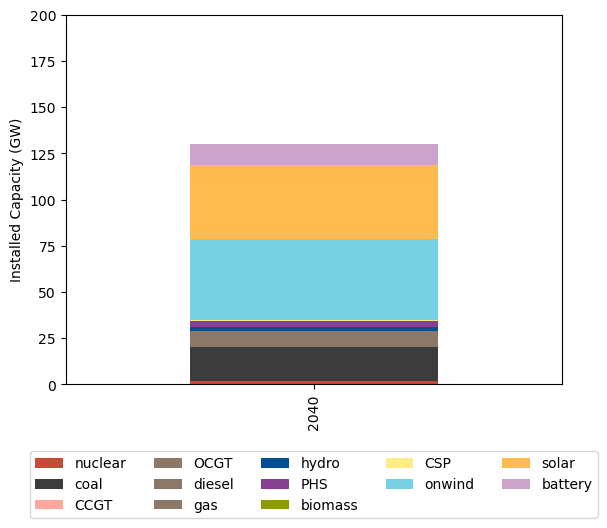

In [8]:
(capacity/1000).T.plot.bar(stacked=True,color=colour_map)
plt.legend(ncol=5,bbox_to_anchor =(0.5,-0.38), loc='lower center')
plt.ylabel('Installed Capacity (GW)')
plt.xlabel("")
plt.ylim([0,200])

(<matplotlib.collections.PatchCollection at 0x7f67fcc09fc0>,
 <matplotlib.collections.LineCollection at 0x7f67fcc0a4d0>)

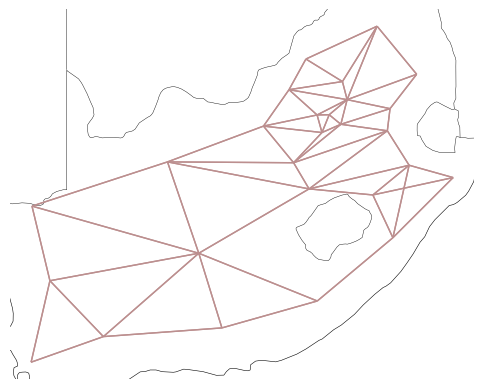

In [11]:
n.plot(line_widths=1,
       bus_sizes=0)

In [113]:
n.generators_t.p['RSA load_shedding'].groupby(n.generators_t.p.index.get_level_values(0)).sum()/1e6

period
2022    0.024486
2025    0.005740
2030    0.007721
Name: RSA load_shedding, dtype: float64

In [115]:
years=n.generators_t.p.index.get_level_values(0)
n.generators_t.p[n.generators[n.generators.carrier.isin(['diesel'])].index].sum(axis=1).groupby(years).sum()/(3056*8760)

period
2022    0.024284
2025    0.000455
2030    0.000408
dtype: float64

In [19]:
n.storage_units.p_nom_opt

StorageUnit
Drakensberg         1000.000000
Ingula              1332.000000
Palmiet              400.000000
Steenbras            180.000000
RSA battery_2022       0.000000
RSA battery_2025       1.043709
RSA battery_2030    4370.912771
RSA battery_2035    3767.221268
RSA battery_2040    3532.688786
RSA battery_2045      34.611385
RSA battery_2050     167.993105
Name: p_nom_opt, dtype: float64

<AxesSubplot: xlabel='period,timestep'>

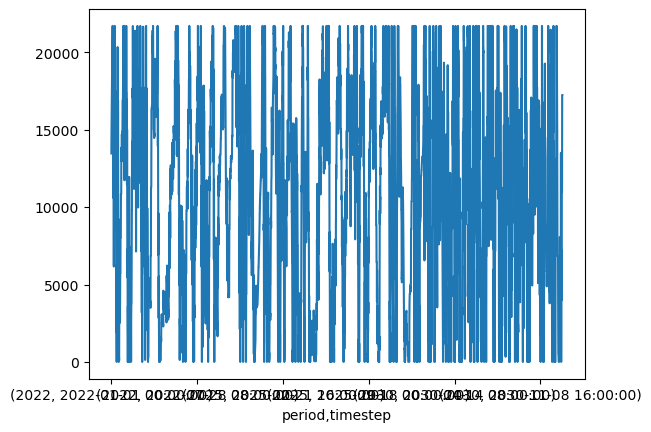

In [86]:
n.storage_units_t.state_of_charge['Drakensberg'].plot()

In [19]:
n.global_constraints[n.global_constraints['sense']=='<=']

,carrier_attribute,sense,investment_period,type,constant,mu
GlobalConstraint,,,,,,
max_period_limit_biomass_2025,biomass,<=,2025.0,tech_capacity_expansion_limit,100000.0,0.000000e+00
max_period_limit_solar_2025,solar,<=,2025.0,tech_capacity_expansion_limit,4000.0,6.977080e+08
max_period_limit_onwind_2025,onwind,<=,2025.0,tech_capacity_expansion_limit,5000.0,1.124587e+09
max_period_limit_CCGT_2025,CCGT,<=,2025.0,tech_capacity_expansion_limit,0.0,3.016649e+09
max_period_limit_OCGT_2025,OCGT,<=,2025.0,tech_capacity_expansion_limit,3000.0,2.993399e+09
max_period_limit_coal_2025,coal,<=,2025.0,tech_capacity_expansion_limit,10000.0,2.430924e+09
max_period_limit_nuclear_2025,nuclear,<=,2025.0,tech_capacity_expansion_limit,2000.0,7.804030e-02
max_period_limit_biomass_2030,biomass,<=,2030.0,tech_capacity_expansion_limit,100000.0,0.000000e+00
max_period_limit_solar_2030,solar,<=,2030.0,tech_capacity_expansion_limit,14000.0,8.964934e+04


In [2]:
eskom_data=du.eskom_data('../data/ESK2791.csv')

In [15]:
eskom_data['other_re_installed'].groupby(eskom_data.index.year).max().to_clipboard()

In [6]:
eskom_data['loadshed_mlr'].groupby(eskom_data.index.year).sum().to_clipboard()

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 


for y in [2017,2018,2019,2020,2021,2022]:
    data=df.loc['Generation Total','PCLF %']
    plt.plot(data[data.index.year==y].values)



In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
stations=df[df.type=='coal'].index.get_level_values(0)

In [ ]:
stations

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
stations=df[df.type=='coal'].index.get_level_values(0).unique()
eaf=pd.DataFrame(0,index=stations,columns=range(2017,2023))
planned=pd.DataFrame(0,index=stations,columns=range(2017,2023))
unplanned=pd.DataFrame(0,index=stations,columns=range(2017,2023))
for s in stations:
    eaf.loc[s,:]=df.loc[s,'EAF %'].groupby(df.loc[s,'EAF %'].index.year).mean()
    planned.loc[s,:]=df.loc[s,'PCLF %'].groupby(df.loc[s,'PCLF %'].index.year).mean()
    unplanned.loc[s,:]=df.loc[s,'UCLF %'].groupby(df.loc[s,'UCLF %'].index.year).mean()+df.loc[s,'OCLF %'].groupby(df.loc[s,'OCLF %'].index.year).mean()

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
df=df[df.type=='coal']
df.index=df.index.get_level_values(1)
variable='EAF %'
type_avg=df.groupby(level=0).mean()
type_avg.drop(['MW','capacity'],axis=1)
type_avg.loc[:,variable].groupby(type_avg.index.year).mean()

In [ ]:
df = pd.read_csv('../data/Eskom EAF data.csv',index_col=[1,0],parse_dates=True)
df['capacity'] = df['EAF %']/100 * df['MW'] 
stations=df[df.type=='coal'].index.get_level_values(0)

installed_capacity=pd.DataFrame(0,index=stations,columns=range(2017,2023))
for s in stations:
    for y in range(2017,2023):
        installed_capacity.loc[s,y]=df.loc[(s,str(y)),'MW'].mean()

In [ ]:
installed_capacity.to_clipboard()

In [ ]:
mean_pclf=type_avg[variable].groupby(type_avg.index.month).mean().to_clipboard()
for y in [2017,2018,2019,2020,2021,2022]:
    plt.plot(type_avg.loc[str(y),variable].values)

plt.plot(mean_pclf.values,'k--',linewidth=3)
plt.legend([2017,2018,2019,2020,2021,2022])

In [ ]:
mean_pclf=coal_plants['UCLF %'].groupby(coal_plants.index.month).mean()
for y in [2017,2018,2019,2020,2021,2022]:
    plt.plot(coal_plants.loc[str(y),'UCLF %'].values)

plt.plot(mean_pclf.values,'k--',linewidth=3)
plt.legend([2017,2018,2019,2020,2021,2022])

In [ ]:
plt.plot(eskom_data['coal_eaf'])
plt.plot(df[df.type=='coal'].groupby('Date').sum()['capacity'].divide(df[df.type=='coal'].groupby('Date').sum()['MW']))
plt.ylabel('Coal fleet EAF')

INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC.nc has buses, carriers, generators, lines, loads, storage_units


<AxesSubplot:xlabel='Generator'>

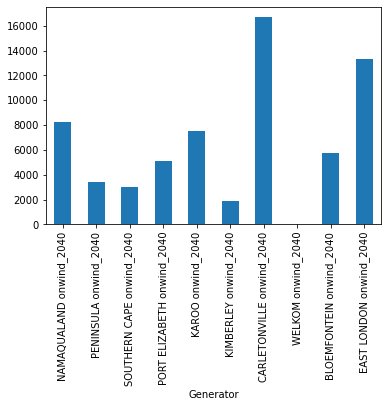

In [18]:
n365 = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC.nc')
n365.generators.p_nom_opt[(n365.get_active_assets('Generator',2040)) & (n365.generators.carrier=='onwind')].plot.bar()

INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC-350p.nc has buses, carriers, generators, lines, loads, storage_units


<AxesSubplot:xlabel='Generator'>

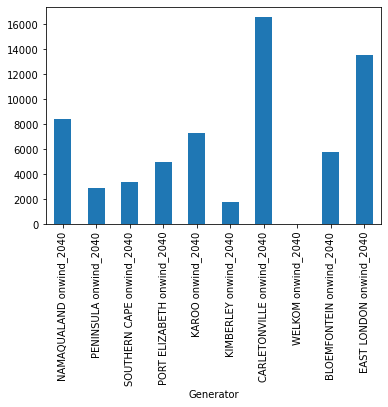

In [22]:
n350 = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-350p.nc')
n350.generators.p_nom_opt[(n350.get_active_assets('Generator',2040)) & (n350.generators.carrier=='onwind')].plot.bar()

In [23]:
n = pypsa.Network('../results/version-0.6/networks/solved_IRP-2019_RSA_redz_lcopt_LC.nc')

INFO:pypsa.io:Imported network solved_IRP-2019_RSA_redz_lcopt_LC.nc has buses, carriers, generators, loads, storage_units


In [62]:
n[25] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-25p.nc')
n[10] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-10p.nc')
n[5] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-5p.nc')

INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC-25p.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC-10p.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC-5p.nc has buses, carriers, generators, lines, loads, storage_units


In [80]:
#s={}
#s[1200] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-1200SEG.nc')
#s[2400] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-2400SEG.nc')
s[3600] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-3600SEG.nc')

INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC-3600SEG.nc has buses, carriers, generators, lines, loads, storage_units


In [38]:
n={}
n[365] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC.nc')
n[350] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-350p.nc')
n[300] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-300p.nc')
n[250] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-250p.nc')
n[200] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-200p.nc')
n[150] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-150p.nc')
n[100] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-100p.nc')
n[50] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-50p.nc')
n[25] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-25p.nc')
n[10] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-10p.nc')
n[50] = pypsa.Network('../results/version-0.6/networks/solved_za-original_27-supply_redz_lcopt_LC-5p.nc')

INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC-350p.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC-300p.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC-250p.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC-200p.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC-150p.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_za-original_27-supply_redz_lcopt_LC-100p.nc has buses, carriers, generators, lines, loads, storage_units
INFO

In [31]:
n.investment_period_weightings

,objective,years
name,,
2025,4.312127,5
2030,2.934761,5
2035,1.997349,5
2040,1.359362,5


In [28]:
n.generators.p_nom_opt[n.get_active_assets('Generator',2025)].groupby(n.generators.carrier).sum()

carrier
CCGT       15273.324689
CSP          600.000000
OCGT       18655.519965
biomass      193.060000
coal       36635.058473
diesel      3072.000000
gas          425.000000
hydro       2447.020000
nuclear     1854.017612
onwind     25481.799337
solar      24999.084064
Name: p_nom_opt, dtype: float64

In [22]:
n.generators.p_nom_opt[n.generators.carrier=='coal']

Generator
Duvha             2875.000000
Grootvlei          570.000000
Hendrina          1098.000000
Kendal            3840.000000
Komati             114.000000
Kriel             2850.000000
Kusile            2880.000000
Lethabo           3558.000000
MajubaDry         1833.000000
MajubaWet         2010.000000
Matimba           3690.000000
Matla             3450.000000
Medupi            3597.000000
Tutuka            3510.000000
Municipal_Coal     160.000000
Sasol_SSF          600.000000
RSA coal_2025        0.061846
RSA coal_2030        0.063909
RSA coal_2035        0.117561
RSA coal_2040        0.661647
Name: p_nom_opt, dtype: float64

In [18]:
n.generators.p_nom_opt[n.generators.carrier=='solar']

Generator
RSA REIPPPP_BW1_solar      625.170000
RSA REIPPPP_BW2_solar      414.000000
RSA REIPPPP_BW3_solar      435.000000
RSA REIPPPP_BW4_solar      812.900000
RSA solar_2025           22712.176992
RSA solar_2030               0.905760
RSA solar_2035            9087.808068
RSA solar_2040            1890.721361
Name: p_nom_opt, dtype: float64

In [63]:
nodes=[5,10,25,50,100,150,200,250,300,350,365]
capacity = pd.DataFrame(0,index=n[365].generators.carrier.unique(),columns=nodes)
for node in nodes:
    p_nom_opt = n[node].generators.p_nom_opt.groupby(n365.generators.carrier).sum()
    for tech in n365.generators.carrier:
        capacity.loc[tech,node] = p_nom_opt[tech]


In [55]:
capacity = pd.DataFrame(0,index=n[365].generators.carrier,columns=nodes)

<AxesSubplot:>

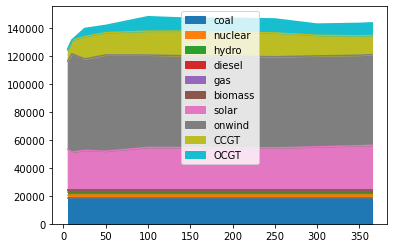

In [64]:
capacity.T.plot.area()

In [ ]:
supply_regions = gpd.read_file(snakemake.input.supply_regions).buffer(-0.005) #.to_crs(n.crs)
resarea = gpd.read_file(snakemake.input.resarea).to_crs(supply_regions.crs)

(<matplotlib.collections.PatchCollection at 0x7f6d10be7f40>,
 <matplotlib.collections.LineCollection at 0x7f6d10be7070>)

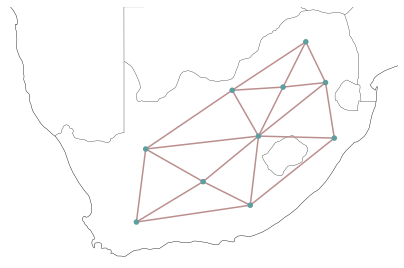

In [38]:
fig, ax = plt.subplots(figsize=[7, 7], subplot_kw={"projection": ccrs.PlateCarree()})
n.plot(ax=ax, boundaries=[14, 34, -35, -22])

In [29]:
n.plot(ax=ax)

(<matplotlib.collections.PatchCollection at 0x7f6d19a628e0>,
 <matplotlib.collections.LineCollection at 0x7f6d19b435e0>)

In [19]:
n.lines[['bus0','bus1','num_parallel','length','s_nom_min']]

,bus0,bus1,num_parallel,length,s_nom_min
Line,,,,,
0,EASTERN CAPE,FREE STATE,0.775623,494.565353,1317.087898
1,EASTERN CAPE,KZN,0.775623,702.781934,1317.087898
2,EASTERN CAPE,NORTHERN CAPE,7.958380,709.406767,13514.145017
4,FREE STATE,GAUTENG,4.712396,381.671114,8002.132162
5,FREE STATE,KZN,1.508830,473.546735,2562.147552
6,FREE STATE,MPUMALANGA,7.225173,569.987267,12269.085363
7,FREE STATE,NORTH WEST,0.775623,366.030831,1317.087898
8,FREE STATE,NORTHERN CAPE,9.509626,674.168985,16148.320813
9,GAUTENG,LIMPOPO,0.366603,354.359250,622.529827


In [18]:
n.lines['s_nom_opt']-n.lines['s_nom_min']

Line
0        0.026466
1      511.364081
2        0.052320
4        0.025606
5      873.306989
6        0.016355
7      574.254739
8        0.016591
9        0.040905
10       0.023069
11    6456.179768
12       0.017079
13       0.028437
14       0.014536
15       0.010777
16       0.096711
dtype: float64

In [255]:
n.generators.p_nom_opt.groupby(n.generators.carrier).sum()

carrier
CCGT       10986.255965
CSP          600.000000
OCGT       19902.625973
biomass      193.060000
coal       18610.042110
diesel      1005.000000
gas          425.000000
hydro       2447.020000
nuclear     1854.062427
onwind     66244.888120
solar      48430.089174
Name: p_nom_opt, dtype: float64

In [237]:
n.storage_units.p_nom_opt.groupby(n.storage_units.carrier=='battery').sum()

carrier
False     2912.000000
True     30977.145211
Name: p_nom_opt, dtype: float64

In [246]:
n.generators_t.p_max_pu['RSA onwind_2040'].mean()

0.36794823059360743

In [245]:
n.generators_t.p['RSA onwind_2040'].mean()/n.generators.p_nom_opt['RSA onwind_2040']

0.31765458296685184

In [253]:
co2_emi = (n.generators_t.p.sum()/n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions)).sum()
co2_emi/1e6

62.6626460703809

In [160]:
n.investment_period_weightings

,objective,years
name,,
2040,1,1


In [ ]:
n.generators_t.p_max_pu.plot()

In [ ]:
# Find the column name and index for all values equal to 5
df = n.vars['Generator']['pnl']['p']
value = 468128
mask = df.eq(value)
result = mask.where(mask).stack()
print(result)
